<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Цель-проекта" data-toc-modified-id="Цель-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Цель проекта</a></span></li><li><span><a href="#Загрузка-и-первичный-обзор-данных" data-toc-modified-id="Загрузка-и-первичный-обзор-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и первичный обзор данных</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Подготовка-к-обучению" data-toc-modified-id="Подготовка-к-обучению-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Подготовка к обучению</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Обучение моделей</a></span></li></ul></li><li><span><a href="#Предсказания-на-тестовой-выборке" data-toc-modified-id="Предсказания-на-тестовой-выборке-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Предсказания на тестовой выборке</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Выявление токсичных комментариев

## Цель проекта

Цель проекта состоит в построении модели, классифицирующей комментарии пользователей на позитивные и негативные (для отправки токсичных комментариев на модерацию). Обучение модели будет происходить на заранее размеченных данных. По требованию заказчика, качество модели будет определяться метрикой *F1*; показатель должен быть не менее 0.75. 

Для достижения поставленной цели необходимо:

1. Подготовить данные, переведя естественный текст в векторную форму;
2. Обучить несколько типов моделей, подобрать оптимальные гиперпараметры;
3. Сравнить качество моделей на кросс-валидации, выбрать модель с наивысшей метрикой;
4. Проверить выбранную модель на тестовой выборке.

Перевод естественного текста в векторный вид будет производиться методов *TF-IDF*. В качестве прогностических моделей будут исследоваться логистическая регрессия, градиентный бустинг и байесовский классификатор.

In [1]:
#!pip install optuna
# Импорты используемых библиотек:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from warnings import filterwarnings
# Лемматизация:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
# Подготовка признаков:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
# Обучение и проверка качества моделей:
import optuna as op
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, make_scorer

# Скачиваем необходимые для лемматизации пакеты:
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('omw-1.4')
#nltk.download('stopwords')

RANDOM_STATE = 1104

## Загрузка и первичный обзор данных

Рассмотрим предоставленные данные:

In [2]:
try:
    df = pd.read_csv('C:/Users/1/python/datasets/toxic_comments.csv', index_col = [0])
except:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col = [0])    

print(df.info())
display(df.sample(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB
None


,text,toxic
25097,Message==\nI've replied to your message on my ...,0
117608,"""\n\n Importance of this dispute \n\nI think t...",0
49688,I put a copy of the thumbnail image into WikiC...,0
7672,"""\n\nPlease do not create articles on your tal...",0
72658,"""presented his researches on ASCE """"Earth and ...",0
62532,"""\nActually, you and Jack are incorrect:\n""""Th...",0
118255,Below i will post the other un block template ...,0
132664,"""\nUpdate per User_talk:Ealdgyth, if Abu Zeyd ...",0
8273,"""\nI've addressed your concerns regarding my p...",0
32445,Probably just someone jealous of her extreme h...,0


Имеющийся корпус текстов содержит ок. 160 тыс. комментариев на английском языке. Явные пропуски отсутствуют. Целевой признак представлен в колонке `toxic`. Рассмотрим соотношение позитивных (0) и негативных (1) комментариев в исходных данных:

In [3]:
print('Соотношение позитивных и негативных комментариев, в %:')
df['toxic'].value_counts(normalize=True)*100

Соотношение позитивных и негативных комментариев, в %:


0    89.838787
1    10.161213
Name: toxic, dtype: float64

Токсичные комментарии составляют ок. 10% от общего числа объектов, т.е. выборка несбалансирована по классам. Дисбаланс нужно будет учесть при разделении выборки на обучающую и тестовую и при обучении моделей.

Рассмотрим, какой приблизительной длины (в количестве слов) комментарии. Длина приблизительная, поскольку в тексте могут быть символьные обозначения, служебные обозначения и т.п., отделенные пробелами, которые при применяемом методе могут быть посчитаны как слова.

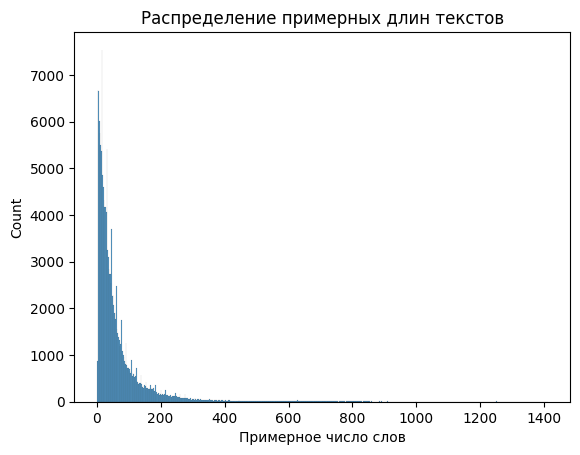

In [4]:
# Определим примерную длину текста в словах:
df['length'] = df['text'].apply(lambda x: len(x.split()))

sns.histplot(data = df,
            x='length')
plt.title('Распределение примерных длин текстов')
plt.xlabel('Примерное число слов')
plt.show()

Видим, что основной массив текстов не превосходит по длине 400 слов. Найдем долю текстов, примерная длина которых больше заданного порога:

In [5]:
len_treshold = 400
print('Доля объектов длиной более {0} составляет {1:.3%} от общей выборки.'.
     format(len_treshold, len(df.query('length > @len_treshold')) / len(df))
     )

Доля объектов длиной более 400 составляет 1.872% от общей выборки.


Доля длинных комментариев невелика. Рассмотрим распределение целевого признака среди длинных комментариев. Если доля токсичных комментариев среди них примерно такая же, как и в целом по выборке, удалим такие комментарии (для упрощения токенизации и, соответсвенно, уменьшения матрицы признаков в дальнейшем).

In [6]:
print('Соотношение позитивных и негативных комментариев среди длинных, в %:')
df.query('length > @len_treshold')['toxic'].value_counts(normalize=True)*100

Соотношение позитивных и негативных комментариев среди длинных, в %:


0    90.17438
1     9.82562
Name: toxic, dtype: float64

Видим, что в целом доля токсичных текстов среди длинных комментариев совпадает с долей по всей выборке. Значит, удаление аномально длинных комментариев не повлияет на распределение классов в выборке, и при этом уменьшит долю "мусорных" признаков при токенизации.

Также удалим явные дубликаты (если они имеются).

In [7]:
df = df.query('length <= @len_treshold').reset_index(drop=True)
df = df.drop_duplicates()

**Вывод:**

Исходные данные представляли собой корпус комментариев размером ок. 160 тыс. объектов, размеченный по классам. Классы несбалансированы: на долю позитивного класса приходится ок. 10% объектов. Из выборки были удалены аномально длинные комментарии (более 400 слов, менее 2% от выборки).

## Лемматизация

Для перевода естественного языка в векторное представление предполагается использовать метод *TF-IDF*. Однако прежде необходимо лемматизитровать текст. 

При этом, для ускорения дальнейшей векторизации (будет осушествляться на каждом шаге кросс-валидации), исключим стоп-слова на этапе лемматизации.

In [8]:
# Стоп-слова, используемые при векторизации:
stopwords = list(nltk.corpus.stopwords.words('english'))
# Функция для определения POS-тег слова для корректной лемматизации:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Функция для лемматизации:
def lemmatization(text):
    # Приводим к нижнему регистру:
    text = text.lower()
    # Избавляемся от знаков препинания, служебных символов и т.п. и стоп-слов:
    clean_text = re.sub(r'[^a-z ]', ' ', text)
    new_text_list = [i for i in clean_text.split() if i not in stopwords]
    new_text = ' '.join(new_text_list)
    # Лемматизируем по списку слов в строке:
    word_list = nltk.word_tokenize(new_text)
    m = WordNetLemmatizer()
    fin_text = ' '.join([m.lemmatize(w,  get_wordnet_pos(w)) for w in word_list])
    return fin_text

*Для ускорения работы лемматизация была проведена единожды и сохранена; дальнейшая работа осуществляется с лемматизированным текстом.*

*Код ниже оставлен для иллюстрации того, как лемматизация была реализована.*

In [9]:
tqdm.pandas()
# Применяем лемматизацию к корпусу текстов:
#df['lemm_text'] = df['text'].progress_apply(lambda x: lemmatization(x))

In [10]:
# Загружаем файл с результатами лемматизации
lemm_df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/fYohnf7YgXFeHw')

Рассмотрим результаты лемматизации:

In [11]:
lemm_df = lemm_df.drop('Unnamed: 0', axis=1)
lemm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156310 entries, 0 to 156309
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       156310 non-null  object
 1   toxic      156310 non-null  int64 
 2   length     156310 non-null  int64 
 3   lemm_text  156249 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.8+ MB


Заметим, что в результате образовалось небольшое количество пропусков в лемматизированном тексте (61 объект, менее 0,1% от выборки). Видимо, такие комметнарии состояли только из стоп-слов и служебных символов (знаков препинания и т.п.). Удалим таким объекты из выборки.

Далее рассмотрим длины лемматизированных текстов в зависимости от токсичности комментария:

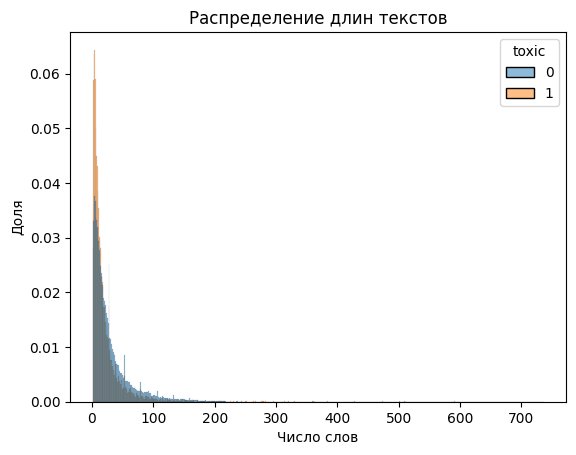

In [12]:
lemm_df = lemm_df.dropna()
lemm_df['lemm_length'] = lemm_df['lemm_text'].apply(lambda x: len(x.split()))

sns.histplot(data=lemm_df,
            x='lemm_length',
            hue='toxic',
            stat='probability',
            common_norm = False)
plt.title('Распределение длин текстов')
plt.xlabel('Число слов')
plt.ylabel('Доля')
plt.show()

В выборке присутствуют аномально длинные комментарии (более 200 токенов). Их количество, судя по гистограммам, невелико, однако затрудняет анализ. Найдем число таких объектов и, если их число невелико, удалим их из выборки:

In [13]:
print('Число комментариев длиной более 200:', \
      len(lemm_df.query('lemm_length > 200')))

Число комментариев длиной более 200: 452


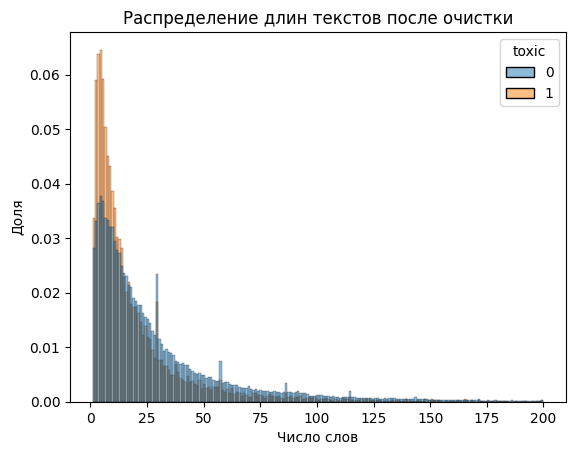

In [14]:
lemm_df = lemm_df.query('lemm_length <= 200')
sns.histplot(data=lemm_df,
            x='lemm_length',
            hue='toxic',
            stat='probability',
            common_norm = False,
            alpha = 0.5)
plt.title('Распределение длин текстов после очистки')
plt.xlabel('Число слов')
plt.ylabel('Доля')
plt.show()

Присутстсуют небольшие различия в длине между токсичными и нормальными комментариями: бОльшая доля токсичных комментариев короткая (до 20 слов). 

## Обучение моделей

Классификаторами будут выступать три типа моделей - логистическая регрессия, байесовский классификатор и градиентный бустинг. Подбор гиперпараметров будет вестить для максимизации метрики *F1*.

При этом, чтобы избежать "утечки" при переводе языка в векторное представление на валидации, воспользуемся инструментом `Pipeline`. Таким образом удастся избежать переобучения. Подбор гиперпараметров будет осуществлятся с помощью фреймворка `Optuna`.


### Подготовка к обучению

Прежде, чем перейти к обучению моделей, подготовим выборки:

In [15]:
# Выделяем выборки:
text = lemm_df['lemm_text']
text = text.apply(lambda x: np.str_(x))
target = lemm_df['toxic']

text_train, text_test, target_train, target_test = train_test_split(text,
                                                                   target,
                                                                   test_size = 0.2,
                                                                   random_state = RANDOM_STATE, 
                                                                   stratify = target)

In [16]:
text_train = text_train.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)

Сформируем цели (т.е. функции максимизации), которые сначала переведут комментарии в векторное представление (**TF-IDF**), а затем на основе полученных векторов обучат классификаторы и проведут кросс-валидацию. По возможности будем использовать встроенное взвешивание классов.

In [17]:
# Логистическая регрессия:

def objective_lr(trial, X, y):  
    # гиперпараметры для перебора:
    param = {'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'saga']),
             'C': trial.suggest_float('C', 0, 7),
             'random_state' : trial.suggest_categorical('random_state', [RANDOM_STATE]),
             'class_weight': trial.suggest_categorical('class_weight', ['balanced'])
            }
    
    # задаем модель для обучения:
    model = LogisticRegression(**param)
    
    pipe = Pipeline(steps = [
        ('tfidf', TfidfVectorizer()),
        ('est', model)
    ])
    
    # задаем алгоритм кросс-валидации:
    cv_method = StratifiedKFold(random_state=RANDOM_STATE,
                               shuffle=True)
    results = cross_validate(pipe, X, y,
                             scoring=make_scorer(f1_score),
                             cv=cv_method,
                             n_jobs=-1)
    return results['test_score'].mean()

In [18]:
# Байесовский классификатор:

def objective_nb(trial, X, y):
    param = {'alpha': trial.suggest_float('alpha', 0, 7)}
    
    model = MultinomialNB(**param)
    
    pipe = Pipeline(steps = [
        ('tfidf', TfidfVectorizer()),
        ('est', model)
    ])
    cv_method = StratifiedKFold(random_state=RANDOM_STATE,
                               shuffle=True)
    results = cross_validate(pipe, X, y,
                             scoring=make_scorer(f1_score),
                             cv=cv_method,
                             n_jobs=-1)
    return results['test_score'].mean()

In [19]:
# Градиентный бустинг LGBM:

def objective_boost(trial, X, y):
    param = {'n_estimators' : trial.suggest_int('n_estimators', 100, 1000, step=50),
             'max_depth' : trial.suggest_int('max_depth', 2, 10),
             'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.6),
             'random_state' : trial.suggest_categorical('random_state', [RANDOM_STATE]),
             'class_weight': trial.suggest_categorical('class_weight', ['balanced'])
            }
    
    model = LGBMClassifier(**param)
    
    pipe = Pipeline(steps = [
        ('tfidf', TfidfVectorizer()),
        ('est', model)
    ])
    cv_method = StratifiedKFold(random_state=RANDOM_STATE,
                               shuffle=True)
    results = cross_validate(pipe, X, y,
                             scoring=make_scorer(f1_score),
                             cv=cv_method,
                             n_jobs=-1)
    return results['test_score'].mean()

### Обучение моделей

Обучим модели с подбором гиперпараметров:

In [20]:
%%time

# Логистическая регрессия:
study_lr = op.create_study(direction="maximize", study_name="Логистическая регрессия")
func_lr = lambda trial: objective_lr(trial, text_train, target_train)
study_lr.optimize(func_lr, n_trials=20)

[I 2023-03-01 14:43:02,659] A new study created in memory with name: Логистическая регрессия
[I 2023-03-01 14:43:17,118] Trial 0 finished with value: 0.752053313983596 and parameters: {'solver': 'newton-cg', 'C': 1.4494289420757172, 'random_state': 1104, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.752053313983596.
[I 2023-03-01 14:43:30,056] Trial 1 finished with value: 0.7604804337602513 and parameters: {'solver': 'liblinear', 'C': 4.404056585847139, 'random_state': 1104, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.7604804337602513.
[I 2023-03-01 14:43:43,208] Trial 2 finished with value: 0.7540231217974329 and parameters: {'solver': 'lbfgs', 'C': 1.7010565496636634, 'random_state': 1104, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.7604804337602513.
[I 2023-03-01 14:44:02,464] Trial 3 finished with value: 0.7526721108343686 and parameters: {'solver': 'saga', 'C': 1.9834812479415498, 'random_state': 1104, 'class_weight': 'balanced'}. Best is

CPU times: total: 1min 55s
Wall time: 4min 38s


In [21]:
%%time

# Байесовский классификатор:
study_nb = op.create_study(direction="maximize", study_name="Байесовский классификатор")
func_nb = lambda trial: objective_nb(trial, text_train, target_train)
study_nb.optimize(func_nb, n_trials=20)

[I 2023-03-01 14:47:41,481] A new study created in memory with name: Байесовский классификатор
[I 2023-03-01 14:47:51,646] Trial 0 finished with value: 0.44792264777890267 and parameters: {'alpha': 0.5759054230238019}. Best is trial 0 with value: 0.44792264777890267.
[I 2023-03-01 14:48:01,701] Trial 1 finished with value: 0.3409930230061221 and parameters: {'alpha': 1.1097718235559833}. Best is trial 0 with value: 0.44792264777890267.
[I 2023-03-01 14:48:11,901] Trial 2 finished with value: 0.12918402529694245 and parameters: {'alpha': 5.767047219708796}. Best is trial 0 with value: 0.44792264777890267.
[I 2023-03-01 14:48:22,031] Trial 3 finished with value: 0.1232186828012934 and parameters: {'alpha': 6.1858280017445075}. Best is trial 0 with value: 0.44792264777890267.
[I 2023-03-01 14:48:32,127] Trial 4 finished with value: 0.1980808736244647 and parameters: {'alpha': 2.939398854918969}. Best is trial 0 with value: 0.44792264777890267.
[I 2023-03-01 14:48:42,184] Trial 5 finished 

CPU times: total: 1min 53s
Wall time: 3min 22s


In [24]:
%%time

# Градиентный бустинг:
study_boost = op.create_study(direction="maximize", study_name="Градиентный бустинг")
func_boost = lambda trial: objective_boost(trial, text_train, target_train)
study_boost.optimize(func_boost, n_trials=20)

[I 2023-03-01 14:57:28,648] A new study created in memory with name: Градиентный бустинг
[I 2023-03-01 14:58:21,843] Trial 0 finished with value: 0.7478033185830938 and parameters: {'n_estimators': 800, 'max_depth': 2, 'learning_rate': 0.2614386961867744, 'random_state': 1104, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7478033185830938.
[I 2023-03-01 14:59:14,352] Trial 1 finished with value: 0.7408037781969092 and parameters: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.06483978823599826, 'random_state': 1104, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7478033185830938.
[I 2023-03-01 15:00:08,314] Trial 2 finished with value: 0.7494156426052598 and parameters: {'n_estimators': 850, 'max_depth': 2, 'learning_rate': 0.3453486673185535, 'random_state': 1104, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.7494156426052598.
[I 2023-03-01 15:02:04,526] Trial 3 finished with value: 0.763293309838904 and parameters: {'n_estimators': 850,

CPU times: total: 1min 54s
Wall time: 30min 15s


Сравним результаты обучения лучших моделей каждого типа:

In [25]:
results_table = pd.Series(index = ["Логистическая регрессия", 
                                   "Байесовский классификатор", 
                                   "Градиентный бустинг"], 
                          dtype='float64')
results_table["Логистическая регрессия"] = study_lr.best_value
results_table["Байесовский классификатор"] = study_nb.best_value
results_table["Градиентный бустинг"] = study_boost.best_value

display(results_table)

Логистическая регрессия      0.760964
Байесовский классификатор    0.662978
Градиентный бустинг          0.769065
dtype: float64

Байесовский классификатор не достиг заданного порога качества *F1* в 0.75.  Наилучший результат показала модель градиетного бустинга (ок. 0.77) со следующими гиперпараметрами: 

In [26]:
best_model_params = study_boost.best_params
print(best_model_params)

{'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.4442856335507108, 'random_state': 1104, 'class_weight': 'balanced'}


## Предсказания на тестовой выборке

Найдем качество модели на тестовой выборке:

In [28]:
# Задаем и обучаем на всей обучающей выборке лучшую модель:
best_model = Pipeline(steps = [('tfidf', TfidfVectorizer()),
                              ('est', LGBMClassifier(**best_model_params))]
                     )
best_model.fit(text_train, target_train)

# Качество на тестовой выборке:
prediction = best_model.predict(text_test)
print('Качество модели на тестовой выборке:', f1_score(target_test, prediction))

Качество модели на тестовой выборке: 0.7820410762617418


Качество модели на тестовой выборке превышает заданный порог.

## Общий вывод

Цель проекта состояла в создании модели, выявляющей токсичные комментарии пользователей на платформе, которые затем будут отправлены на модерацию. Для обучения модели был предоставлен заранее размеченный корпус текстов (ок. 160 тыс. комментариев).

Для ускорения лемматизации и устранения возможных "мусорных" признаков из выборки были удалены аномально длинные комментарии (примерная блина более 400 слов). Предоставленная выборка не сбалансирована по классам - на долю позитивного класса (т.е. токсичных комментариев) приходится ок. 10% объектов. 

Выборка была разделена на обучающую (кросс-валидация) и тестовую выборки в соотношении 80% : 20%. Была проведена лемматизация комментариев для дальнейшего перевода в вектора методом *TF-IDF*. 

Были обучены три типа моделей: логистическая регрессия, градиентный бустинг и байесовский классификатор. Байесовский классификатор не достиг требуемого уровня метрики *F1*; наилучший результат на кросс-валидации (0.772) показала модель градиентного бустинга.

Т.е. для мониторинга комментариев предлагается использовать модель **градиентного бустинга**.